<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº5
#### Federico Borello

Hago uso de un módulo llamado `pds_utils` ubicado en el directorio base del repositorio

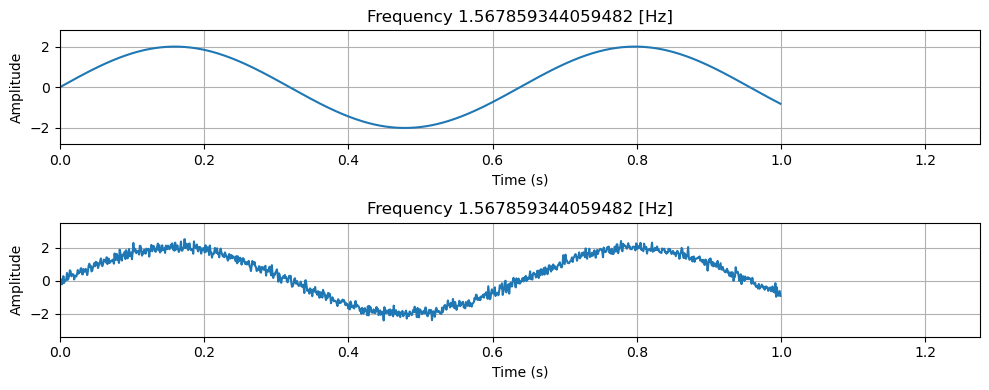

In [118]:
# @title: Generación de Ruido Uniforme Normalizado
import sys
import os

sys.path.append(os.path.abspath(".."))
from pds_utils import plotter, sine, noise

import numpy as np

amplitude = 2

# Señal a cuantizar
fs = N = 1000
spectral_res = fs / N
frequency_factor = np.random.uniform(low=-1 / 2, high=1 / 2, size=None)
omega_0 = np.pi / 2
omega_1 = omega_0 + frequency_factor * 2 * np.pi / N
f = omega_1

t, sr = sine.wave(
    sampling_freq=fs, samples=N, amplitude=amplitude, dc_level=0, frequency=f
)

# SNR
snr = 10
sigma_n_sq = np.var(sr) / (10 ** (snr / 10))
sn, n = noise.normal(sr, 0, sigma_n_sq, N)

# Se grafica la señal real y con ruido
plotter.multiple([(t, sr, f), (t, sn, f)])


## Estimador

$$\hat{a_i} = \left| X_{i \, , \frac{N}{4}} \right|$$

In [111]:
X_evaluated_at_N_over_4 = []
number_of_experiments = 200

X_matrix = np.zeros((number_of_experiments, N), dtype=complex)

for experiment in range(0, number_of_experiments):
    frequency_factor = np.random.uniform(low=-1 / 2, high=1 / 2, size=None)
    omega_1 = omega_0 + frequency_factor * 2 * np.pi / N
    f = omega_1 / (2 * np.pi)

    t, sr = sine.wave(
        sampling_freq=fs, samples=N, amplitude=amplitude, dc_level=0, frequency=f
    )

    # SNR
    snr = 10
    sigma_n_sq = np.var(sr) / (10 ** (snr / 10))
    sn, n = noise.normal(sr, 0, sigma_n_sq, N)

    # FFT
    X = np.fft.fft(sn) / N
    X_matrix[experiment] = X

X_evaluated_at_N_over_4 = np.abs(
    X_matrix[:, N // 4]
)

np.var(X_evaluated_at_N_over_4)

5.10912180610974e-07